# Data integration

# Integration inspection

In [5]:
import xarray as xr
import numpy as np
import pandas as pd

# ============================================================
# USER: SET YOUR FILE PATHS HERE
# ============================================================
paths = {
    "CO2":  r"C:\Users\tanvi\Capstone\CO2\CAMS_CO2_Australasia_2015_2025.nc",
    "CH4":  r"C:\Users\tanvi\Capstone\CH4\CH4_Australasia.nc",
    "NO2":  r"CAMS_NO2_topdown_Australasia_2015_2025.nc",
    "N2O":  r"C:\Users\tanvi\Capstone\N2O_topdown\CAMS_N2O_topdown_Australasia_2015_2022.nc",
}

# ============================================================
# STORAGE
# ============================================================
results = []

# ============================================================
# INSPECTION FUNCTION
# ============================================================
def inspect_dataset(name, path):
    try:
        ds = xr.open_dataset(path)
    except Exception as e:
        print(f"ERROR opening {name}: {e}")
        return None
    
    print(f"\n\n====================== {name} ======================")
    print(f"File: {path}")

    # Detect coordinate names
    lat_name = "latitude" if "latitude" in ds.coords else "lat"
    lon_name = "longitude" if "longitude" in ds.coords else "lon"
    time_name = "time" if "time" in ds.coords else "Time"

    # Only use the main variable
    var = list(ds.data_vars)[0]
    da = ds[var]

    # Resolution
    lat_vals = ds[lat_name].values
    lon_vals = ds[lon_name].values

    lat_res = np.round(np.abs(lat_vals[1] - lat_vals[0]), 4) if len(lat_vals) > 1 else None
    lon_res = np.round(np.abs(lon_vals[1] - lon_vals[0]), 4) if len(lon_vals) > 1 else None

    # Units
    units = da.attrs.get("units", "Not found")

    # Date range
    tvals = ds[time_name].values
    start = str(tvals[0])[:10]
    end   = str(tvals[-1])[:10]

    # NaNs/Infs
    vals = da.values
    nan_ct = np.isnan(vals).sum()
    inf_ct = np.isinf(vals).sum()

    # Crop bounds
    lat_min, lat_max = float(lat_vals.min()), float(lat_vals.max())
    lon_min, lon_max = float(lon_vals.min()), float(lon_vals.max())

    print(f"\nVariable: {var}")
    print(f"Units: {units}")
    print(f"Resolution: {lat_res}° × {lon_res}°")
    print(f"Latitude range: {lat_min} → {lat_max}  (n={len(lat_vals)})")
    print(f"Longitude range: {lon_min} → {lon_max} (n={len(lon_vals)})")
    print(f"Time: {start} → {end}  (n={len(tvals)})")
    print(f"Shape: {tuple(da.shape)}")
    print(f"NaNs: {nan_ct}")
    print(f"Infs: {inf_ct}")

    # Latitude Ordering
    ordering = "ascending" if lat_vals[1] > lat_vals[0] else "descending"
    print(f"Latitude order: {ordering}")

    # Save to results table
    results.append([
        name, var, units,
        lat_res, lon_res,
        lat_min, lat_max, lon_min, lon_max,
        start, end,
        da.shape[0], da.shape[1], da.shape[2],
        nan_ct, inf_ct
    ])


# ============================================================
# RUN INSPECTION
# ============================================================
for name, path in paths.items():
    inspect_dataset(name, path)

# ============================================================
# SUMMARY TABLE
# ============================================================
columns = [
    "Gas", "Variable", "Units",
    "Lat Res", "Lon Res",
    "Lat Min", "Lat Max", "Lon Min", "Lon Max",
    "Start Date", "End Date",
    "N_time", "N_lat", "N_lon",
    "NaNs", "Infs"
]

df = pd.DataFrame(results, columns=columns)

print("\n\n====================== INTEGRATION SUMMARY TABLE ======================")
print(df.to_string(index=False))




====================== CO2 ======================
File: C:\Users\tanvi\Capstone\CO2\CAMS_CO2_Australasia_2015_2025.nc

Variable: flux_apri_bio
Units: kgC m-2 month-1
Resolution: 1.0° × 1.0°
Latitude range: -49.5 → -0.5  (n=50)
Longitude range: 110.5 → 179.5 (n=70)
Time: 2015-01-15 → 2025-03-15  (n=123)
Shape: (123, 50, 70)
NaNs: 0
Infs: 0
Latitude order: ascending


====================== CH4 ======================
File: C:\Users\tanvi\Capstone\CH4\CH4_Australasia.nc

Variable: tc_ch4
Units: kg m**-2
Resolution: 0.75° × 0.7516°
Latitude range: -49.5 → -10.5  (n=53)
Longitude range: 110.48016701461378 → 179.6242171189979 (n=93)
Time: 2015-01-01 → 2024-12-01  (n=120)
Shape: (120, 53, 93)
NaNs: 0
Infs: 0
Latitude order: descending


====================== NO2 ======================
File: CAMS_NO2_topdown_Australasia_2015_2025.nc

Variable: ColumnAmountNO2TropCloudScreened
Units: Not found
Resolution: 0.2503° × 0.2502°
Latitude range: -49.944367176634216 → -10.13908205841446  (n=160)
Lon

In [7]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

sns.set(style="whitegrid")

# ---------------------------
# Create EDA save directory
# ---------------------------
eda_dir = r"C:\Users\tanvi\Capstone\EDA"
os.makedirs(eda_dir, exist_ok=True)

def save_plot(fig, filename):
    out_path = os.path.join(eda_dir, filename)
    fig.savefig(out_path, dpi=200, bbox_inches="tight")
    plt.close(fig)
    print("Saved:", out_path)

# Top-Down Gases
# NO2

## Load + clean + basic stats

In [11]:
# ------------------------------
# Load NO2 Dataset
# ------------------------------
no2_path = r"CAMS_NO2_topdown_Australasia_2015_2025.nc"
var_no2 = "ColumnAmountNO2TropCloudScreened"

ds_no2 = xr.open_dataset(no2_path)
da_no2 = ds_no2[var_no2].where(ds_no2[var_no2] > 0)  # remove negatives
da_no2


<xarray.DataArray 'ColumnAmountNO2TropCloudScreened' (Time: 129, lat: 160,
                                                      lon: 360)> Size: 30MB
array([[[           nan, 4.51596643e+13, 1.27645187e+14, ...,
         2.27059452e+14, 2.72688984e+14, 1.91380589e+14],
        [           nan,            nan, 1.32707468e+14, ...,
         2.20286171e+14, 1.25138813e+14, 1.13463213e+14],
        [7.53502771e+13, 3.01635302e+13, 1.32151564e+14, ...,
         3.51746413e+14, 1.35892254e+14, 1.08950679e+14],
        ...,
        [3.52934534e+13, 1.06304501e+14, 1.07631335e+14, ...,
         3.23590176e+13, 9.99377569e+13, 1.04002725e+14],
        [1.20287153e+14, 1.42597645e+14, 7.98981525e+13, ...,
         1.16610409e+14, 1.13477834e+14, 5.90073561e+13],
        [6.34722682e+13, 5.82980196e+13, 1.10685359e+14, ...,
         4.24286817e+13, 1.98738354e+14, 3.02559600e+13]],

       [[2.04531963e+14, 1.71182582e+14, 2.29139894e+14, ...,
         2.64026941e+14, 3.34327334e+14, 2.17358497e+14],
        [9.87203518e+13, 2.70665081e+14, 2.65449464e+14, ...,
         3.13379302e+14, 3.52695467e+14, 1.56561574e+14],
        [           nan, 3.02538268e+14, 3.09904506e+14, ...,
         3.04674276e+14, 1.93327970e+14, 2.01686363e+14],
...
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [1.03155660e+14,            nan,            nan, ...,
                    nan,            nan,            nan],
        [1.95149288e+14, 6.15696564e+13, 9.21991066e+13, ...,
         4.66767818e+13,            nan,            nan]],

       [[           nan, 6.27893416e+14, 5.30081374e+14, ...,
         3.82278128e+14, 3.91460499e+14, 2.67730897e+14],
        [           nan, 5.42386019e+14, 8.68944898e+14, ...,
         5.64846383e+14, 3.01222465e+14, 3.58087093e+14],
        [1.72822857e+14, 5.60063467e+14, 4.56491438e+14, ...,
         6.69825584e+14, 4.50766951e+14, 2.18882640e+14],
        ...,
        [           nan,            nan, 1.42871802e+14, ...,
                    nan,            nan,            nan],
        [           nan,            nan, 1.17292998e+13, ...,
                    nan,            nan,            nan],
        [           nan, 1.72212387e+13,            nan, ...,
                    nan, 1.96999211e+14,            nan]]], dtype=float32)
Coordinates:
  * Time     (Time) datetime64[ns] 1kB 2015-01-01 2015-02-01 ... 2025-09-01
  * lat      (lat) float64 1kB -49.94 -49.69 -49.44 ... -10.64 -10.39 -10.14
  * lon      (lon) float64 3kB 90.19 90.44 90.69 90.94 ... 179.5 179.7 180.0

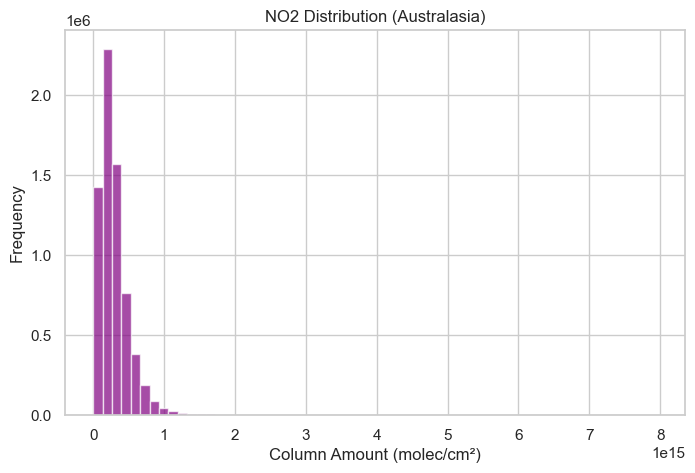

Saved: C:\Users\tanvi\Capstone\EDA\NO2_hist.png


In [16]:
fig = plt.figure(figsize=(8,5))
plt.hist(da_no2.values.flatten(), bins=60, color="purple", alpha=0.7)
plt.title("NO2 Distribution (Australasia)")
plt.xlabel("Column Amount (molec/cm²)")
plt.ylabel("Frequency")
plt.show()

save_plot(fig, "NO2_hist.png")


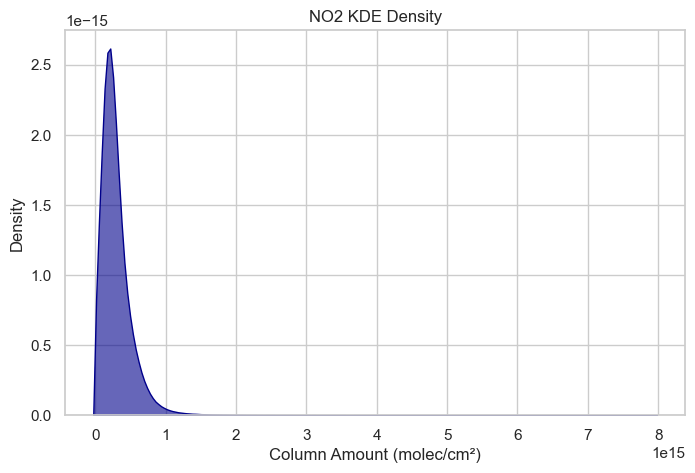

Saved: C:\Users\tanvi\Capstone\EDA\NO2_kde.png


In [49]:
fig = plt.figure(figsize=(8,5))
sns.kdeplot(
    da_no2.values.flatten()[~np.isnan(da_no2.values.flatten())],
    fill=True,
    color="darkblue",
    alpha=0.6
)
plt.title("NO2 KDE Density")
plt.xlabel("Column Amount (molec/cm²)")
plt.show()

save_plot(fig, "NO2_kde.png")


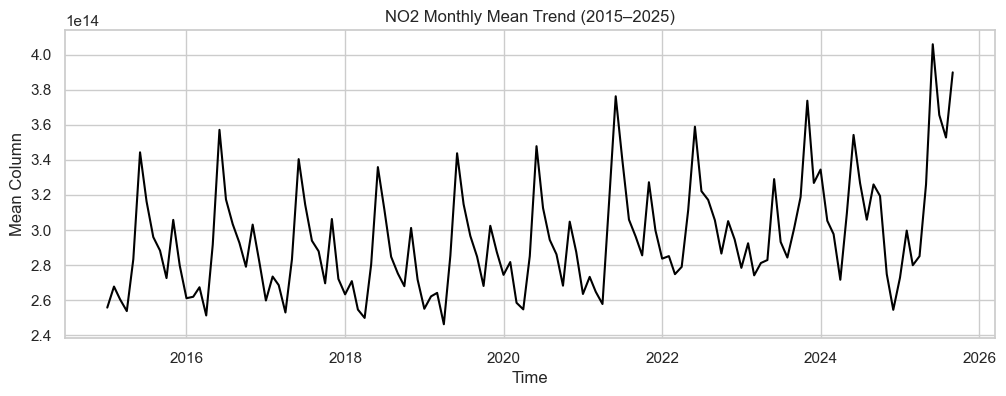

Saved: C:\Users\tanvi\Capstone\EDA\NO2_line_trend.png


In [50]:
no2_ts = da_no2.mean(dim=["lat", "lon"]).to_pandas()

fig = plt.figure(figsize=(12,4))
plt.plot(no2_ts.index, no2_ts.values, color="black")
plt.title("NO2 Monthly Mean Trend (2015–2025)")
plt.xlabel("Time")
plt.ylabel("Mean Column")
plt.show()

save_plot(fig, "NO2_line_trend.png")


C:\Users\tanvi\AppData\Local\Temp\ipykernel_33136\3219901303.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  no2_monthly = no2_ts.resample("M").mean()


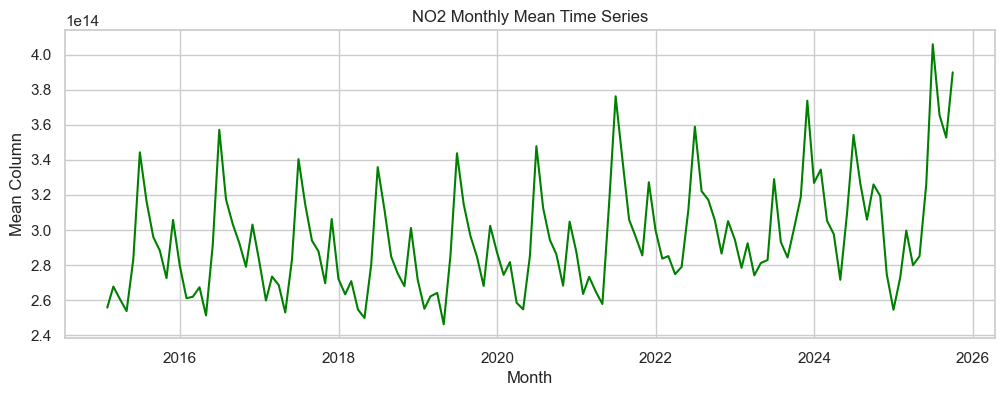

Saved: C:\Users\tanvi\Capstone\EDA\NO2_monthly_ts.png


In [51]:
no2_monthly = no2_ts.resample("M").mean()

fig = plt.figure(figsize=(12,4))
plt.plot(no2_monthly.index, no2_monthly.values, color="green")
plt.title("NO2 Monthly Mean Time Series")
plt.xlabel("Month")
plt.ylabel("Mean Column")
plt.show()

save_plot(fig, "NO2_monthly_ts.png")


C:\Users\tanvi\AppData\Local\Temp\ipykernel_33136\723427998.py:1: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  no2_annual = no2_ts.resample("Y").mean()


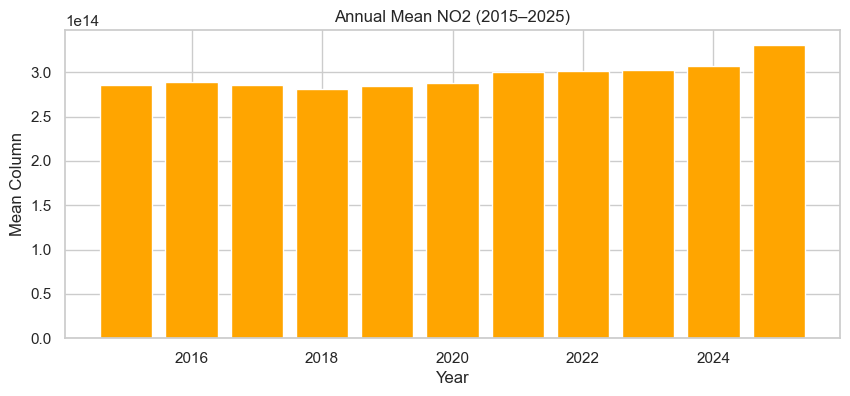

Saved: C:\Users\tanvi\Capstone\EDA\NO2_annual_bar.png


In [52]:
no2_annual = no2_ts.resample("Y").mean()

fig = plt.figure(figsize=(10,4))
plt.bar(no2_annual.index.year, no2_annual.values, color="orange")
plt.title("Annual Mean NO2 (2015–2025)")
plt.xlabel("Year")
plt.ylabel("Mean Column")
plt.show()

save_plot(fig, "NO2_annual_bar.png")


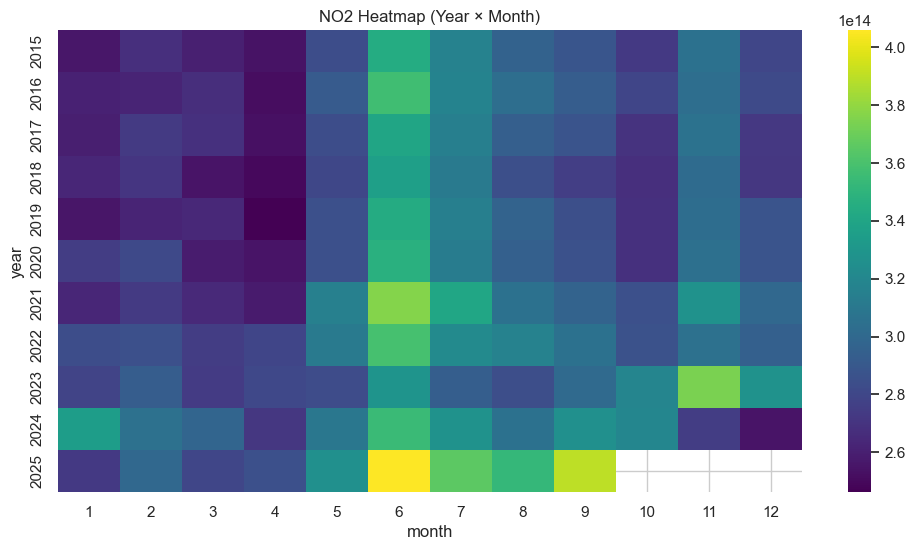

Saved: C:\Users\tanvi\Capstone\EDA\NO2_year_month_heatmap.png


In [26]:
df = da_no2.mean(dim=["lat","lon"]).to_pandas()

df_hm = df.to_frame(name="value")
df_hm["year"] = df_hm.index.year
df_hm["month"] = df_hm.index.month

heatmap_data = df_hm.pivot_table(index="year", columns="month", values="value")

fig = plt.figure(figsize=(12,6))
sns.heatmap(heatmap_data, cmap="viridis")
plt.title("NO2 Heatmap (Year × Month)")
plt.show()

save_plot(fig, "NO2_year_month_heatmap.png")


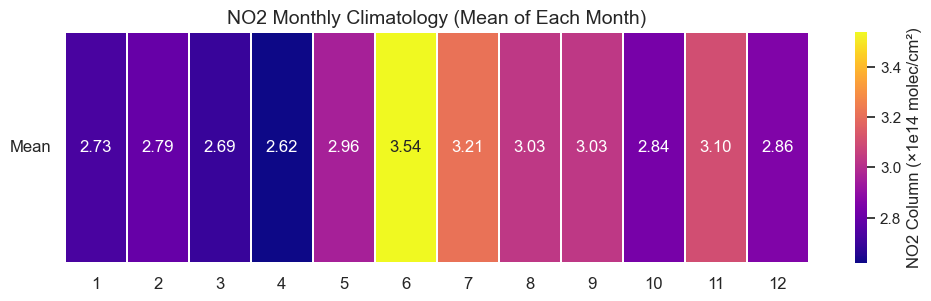

Saved: C:\Users\tanvi\Capstone\EDA\NO2_monthly_climatology.png


In [37]:
# -----------------------------------------
# Cleaned & Improved Monthly Climatology
# -----------------------------------------

# Compute monthly mean using your df_hm
df_clim = df_hm.groupby("month")["value"].mean()

# Scale values for readability (1e14)
scaled_vals = (df_clim.values / 1e14).reshape(1, 12)

fig = plt.figure(figsize=(12, 3))

ax = sns.heatmap(
    scaled_vals,
    cmap="plasma",
    annot=True,
    fmt=".2f",
    cbar_kws={"label": "NO2 Column (×1e14 molec/cm²)"},
    linewidths=0.3,
    annot_kws={"size": 12}
)

# x-axis = months
plt.xticks(
    ticks=np.arange(12) + 0.5,
    labels=range(1, 13),
    rotation=0,
    fontsize=12
)

# remove y-axis ticks
plt.yticks([0.5], ["Mean"], rotation=0, fontsize=12)

plt.title("NO2 Monthly Climatology (Mean of Each Month)", fontsize=14)

plt.show()

save_plot(fig, "NO2_monthly_climatology.png")


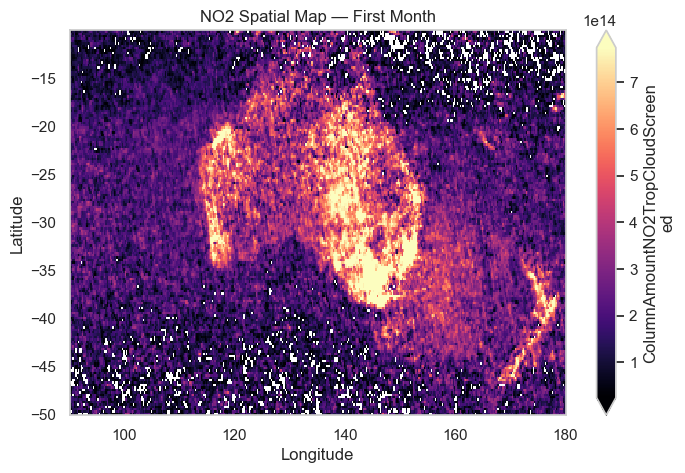

Saved: C:\Users\tanvi\Capstone\EDA\NO2_map_firstmonth.png


In [167]:
# ============================
# NO2 — SPATIAL MAP (FIRST)
# ============================

fig = plt.figure(figsize=(8,5))

da_no2.isel(Time=0).plot(
    cmap="magma",
    robust=True
)

plt.title("NO2 Spatial Map — First Month")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

save_plot(fig, "NO2_map_firstmonth.png")


# CO2

In [75]:
# ===========================
#       CO₂ (Top-down)
# ===========================

co2_path = r"C:\Users\tanvi\Capstone\CO2\CAMS_CO2_Australasia_2015_2025.nc"
ds_co2 = xr.open_dataset(co2_path)

var_co2 = "co2_flux_total"   # Net posterior CO₂ flux
da_co2 = ds_co2[var_co2]

print("Loaded CO₂ variable:", da_co2)


Loaded CO₂ variable: <xarray.DataArray 'co2_flux_total' (time: 123, latitude: 50, longitude: 70)> Size: 3MB
[430500 values with dtype=float64]
Coordinates:
  * time       (time) datetime64[ns] 984B 2015-01-15 2015-02-15 ... 2025-03-15
  * latitude   (latitude) float64 400B -49.5 -48.5 -47.5 ... -2.5 -1.5 -0.5
  * longitude  (longitude) float64 560B 110.5 111.5 112.5 ... 177.5 178.5 179.5


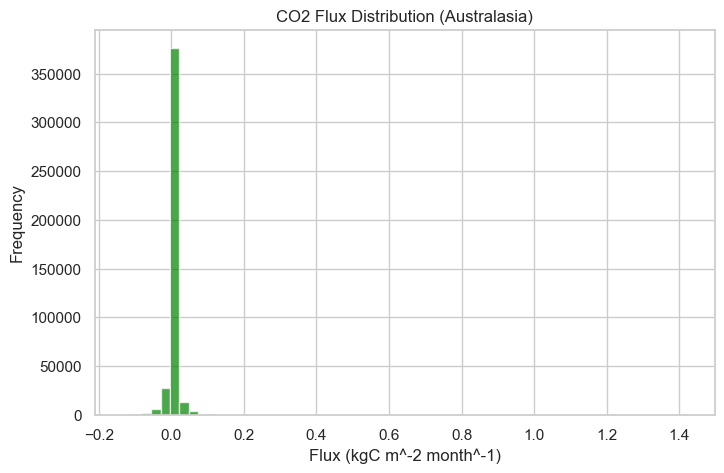

Saved: C:\Users\tanvi\Capstone\EDA\CO2_hist.png


In [77]:
fig = plt.figure(figsize=(8,5))
plt.hist(da_co2.values.flatten(), bins=60, color="green", alpha=0.7)
plt.title("CO2 Flux Distribution (Australasia)")
plt.xlabel("Flux (kgC m^-2 month^-1)")
plt.ylabel("Frequency")
plt.show()

save_plot(fig, "CO2_hist.png")


C:\Users\tanvi\AppData\Local\Temp\ipykernel_33136\3686258095.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(da_co2.values.flatten(), shade=True, color="darkgreen")


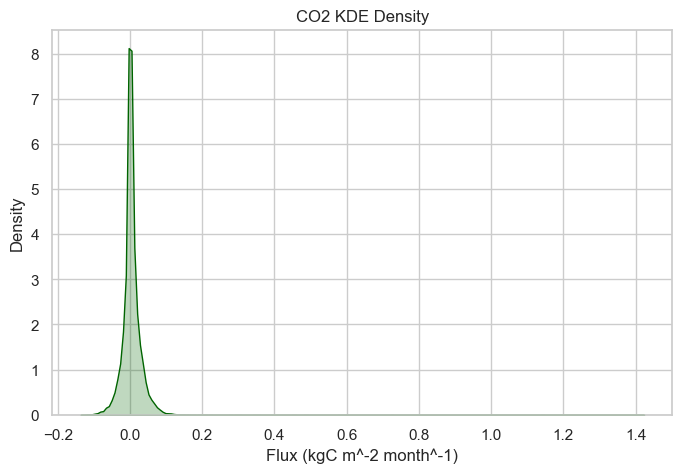

Saved: C:\Users\tanvi\Capstone\EDA\CO2_kde.png


In [79]:
fig = plt.figure(figsize=(8,5))
sns.kdeplot(da_co2.values.flatten(), shade=True, color="darkgreen")
plt.title("CO2 KDE Density")
plt.xlabel("Flux (kgC m^-2 month^-1)")
plt.show()

save_plot(fig, "CO2_kde.png")



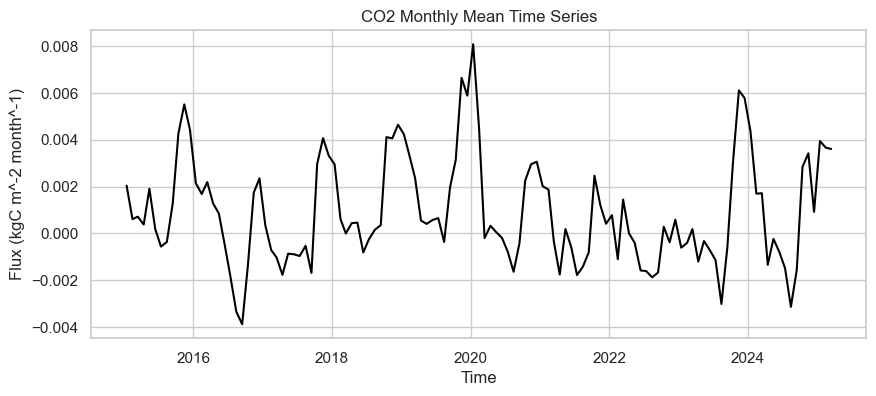

Saved: C:\Users\tanvi\Capstone\EDA\CO2_timeseries.png


In [81]:
co2_ts = da_co2.mean(dim=["latitude", "longitude"]).to_pandas()

fig = plt.figure(figsize=(10,4))
plt.plot(co2_ts.index, co2_ts.values, color="black")
plt.title("CO2 Monthly Mean Time Series")
plt.xlabel("Time")
plt.ylabel("Flux (kgC m^-2 month^-1)")
plt.show()

save_plot(fig, "CO2_timeseries.png")



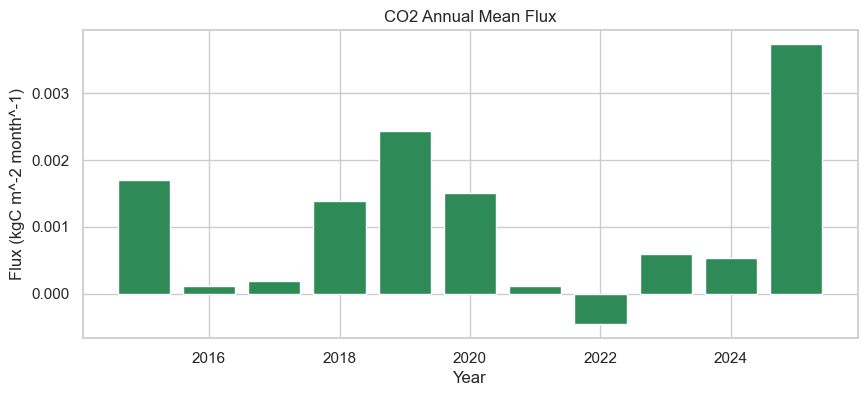

Saved: C:\Users\tanvi\Capstone\EDA\CO2_annual_bar.png


In [83]:
co2_annual = co2_ts.groupby(co2_ts.index.year).mean()

fig = plt.figure(figsize=(10,4))
plt.bar(co2_annual.index, co2_annual.values, color="seagreen")
plt.title("CO2 Annual Mean Flux")
plt.xlabel("Year")
plt.ylabel("Flux (kgC m^-2 month^-1)")
plt.show()

save_plot(fig, "CO2_annual_bar.png")


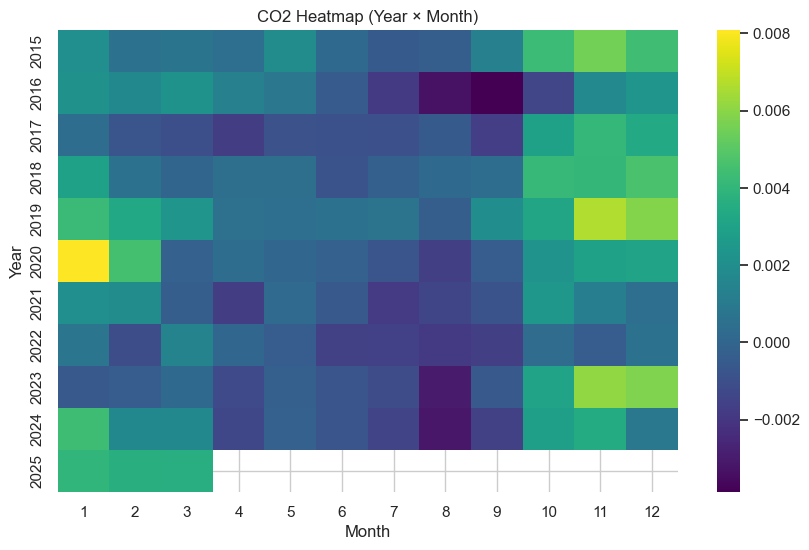

Saved: C:\Users\tanvi\Capstone\EDA\CO2_heatmap_year_month.png


In [87]:
df_hm = da_co2.mean(dim=["latitude","longitude"]).to_dataframe().reset_index()
df_hm["year"] = df_hm["time"].dt.year
df_hm["month"] = df_hm["time"].dt.month

pivot = df_hm.pivot_table(values=var_co2, index="year", columns="month")

fig = plt.figure(figsize=(10,6))
sns.heatmap(pivot, cmap="viridis", annot=False)
plt.title("CO2 Heatmap (Year × Month)")
plt.xlabel("Month")
plt.ylabel("Year")
plt.show()

save_plot(fig, "CO2_heatmap_year_month.png")


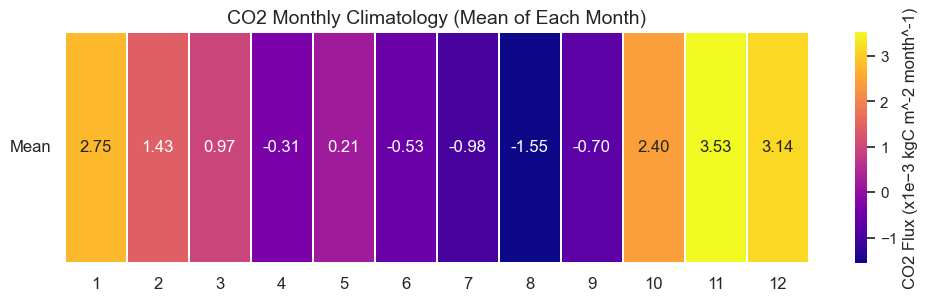

Saved: C:\Users\tanvi\Capstone\EDA\CO2_monthly_climatology.png


In [97]:
# -----------------------------------------
# CO2 Monthly Climatology (Improved Style)
# -----------------------------------------

# df_hm already exists from earlier:
# df_hm["year"], df_hm["month"], df_hm[var_co2]

# Compute monthly mean
df_clim_co2 = df_hm.groupby("month")[var_co2].mean()

# OPTIONAL: scale values (CO2 flux tends to be small)
# adjust denominator as needed after seeing raw units
scaled_vals = (df_clim_co2.values / 1e-3).reshape(1, 12)

fig = plt.figure(figsize=(12, 3))

ax = sns.heatmap(
    scaled_vals,
    cmap="plasma",
    annot=True,
    fmt=".2f",
    cbar_kws={"label": "CO2 Flux (x1e−3 kgC m^-2 month^-1)"},
    linewidths=0.3,
    annot_kws={"size": 12}
)

# x-axis = months (1 to 12)
plt.xticks(
    ticks=np.arange(12) + 0.5,
    labels=range(1, 13),
    rotation=0,
    fontsize=12
)

# y-axis: single row labelled “Mean”
plt.yticks([0.5], ["Mean"], rotation=0, fontsize=12)

plt.title("CO2 Monthly Climatology (Mean of Each Month)", fontsize=14)

plt.show()

save_plot(fig, "CO2_monthly_climatology.png")


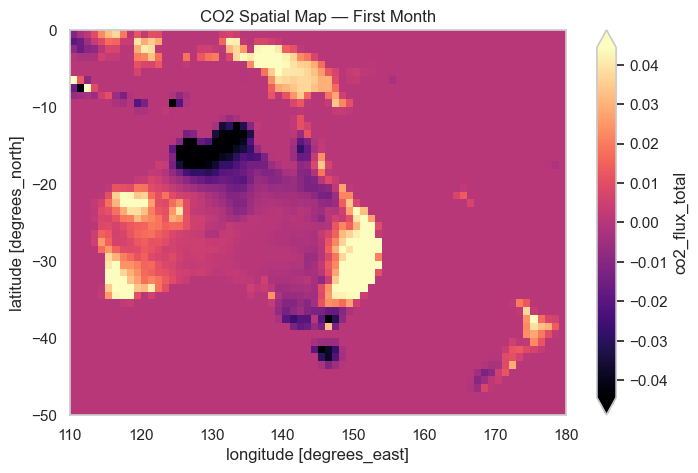

Saved: C:\Users\tanvi\Capstone\EDA\CO2_map_firstmonth.png


In [91]:
fig = plt.figure(figsize=(8,5))
da_co2.isel(time=0).plot(cmap="magma", robust=True)
plt.title("CO2 Spatial Map — First Month")
plt.show()

save_plot(fig, "CO2_map_firstmonth.png")


# CH4

In [104]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

sns.set(style="whitegrid")

# ==== your EDA save function ====
eda_dir = r"C:\Users\tanvi\Capstone\EDA"
os.makedirs(eda_dir, exist_ok=True)

def save_plot(fig, filename):
    out_path = os.path.join(eda_dir, filename)
    fig.savefig(out_path, dpi=200, bbox_inches="tight")
    plt.close(fig)
    print("Saved:", out_path)

# ================================
# LOAD CH₄ DATASET
# ================================
ch4_path = r"C:\Users\tanvi\Capstone\CH4\CH4_Australasia.nc"

ds_ch4 = xr.open_dataset(ch4_path)

var_ch4 = "tc_ch4"   # variable name

da_ch4 = ds_ch4[var_ch4]   # extract DataArray

print(da_ch4)


<xarray.DataArray 'tc_ch4' (time: 120, lat: 53, lon: 93)> Size: 2MB
[591480 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 960B 2015-01-01 2015-02-01 ... 2024-12-01
  * lat      (lat) float64 424B -10.5 -11.25 -12.0 -12.75 ... -48.0 -48.75 -49.5
  * lon      (lon) float64 744B 110.5 111.2 112.0 112.7 ... 178.1 178.9 179.6
Attributes:
    standard_name:  atmosphere_mass_content_of_methane
    long_name:      Total column methane
    units:          kg m**-2
    code:           4
    table:          218


In [134]:
# Clean CH4
da_ch4_clean = da_ch4.where(np.isfinite(da_ch4))

# Mean over space
ts = da_ch4_clean.mean(dim=["lat", "lon"])   # <-- FIXED

# Convert to pandas
df_ch4 = ts.to_dataframe().reset_index()
df_ch4.columns = ["time", "value"]

print(df_ch4.head())

df_ch4["year"] = df_ch4["time"].dt.year
df_ch4["month"] = df_ch4["time"].dt.month




        time     value
0 2015-01-01  0.009681
1 2015-02-01  0.009713
2 2015-03-01  0.009709
3 2015-04-01  0.009750
4 2015-05-01  0.009751


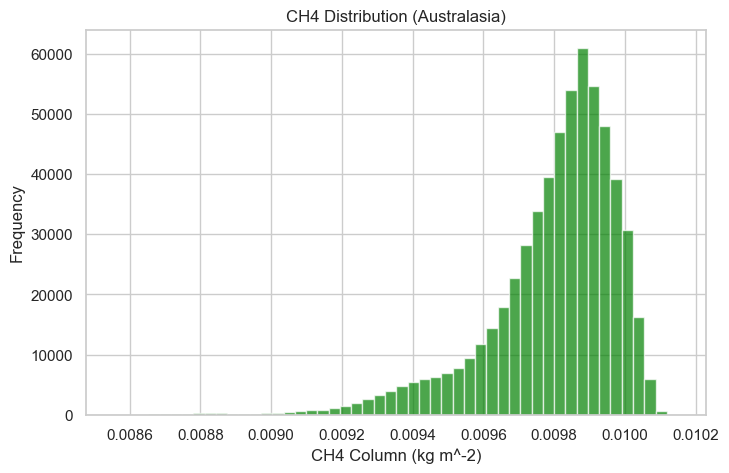

Saved: C:\Users\tanvi\Capstone\EDA\CH4_hist.png


In [110]:
fig = plt.figure(figsize=(8,5))
plt.hist(da_ch4_clean.values.flatten(), bins=50, color="green", alpha=0.7)
plt.title("CH4 Distribution (Australasia)")
plt.xlabel("CH4 Column (kg m^-2)")
plt.ylabel("Frequency")
plt.show()

save_plot(fig, "CH4_hist.png")


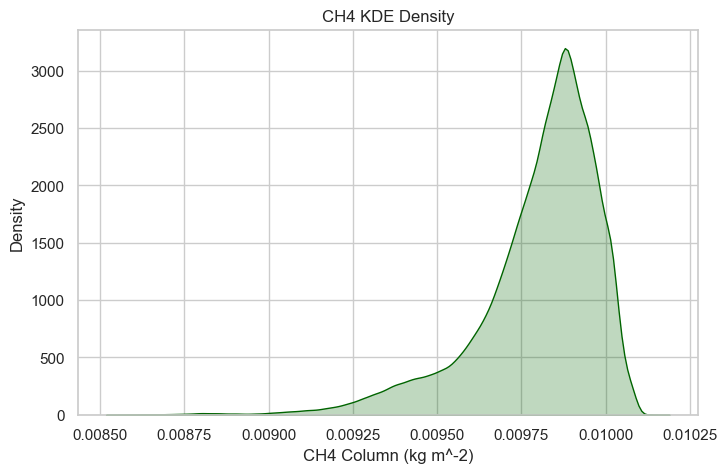

Saved: C:\Users\tanvi\Capstone\EDA\CH4_kde.png


In [112]:
fig = plt.figure(figsize=(8,5))
sns.kdeplot(da_ch4_clean.values.flatten(), fill=True, color="darkgreen")
plt.title("CH4 KDE Density")
plt.xlabel("CH4 Column (kg m^-2)")
plt.show()

save_plot(fig, "CH4_kde.png")


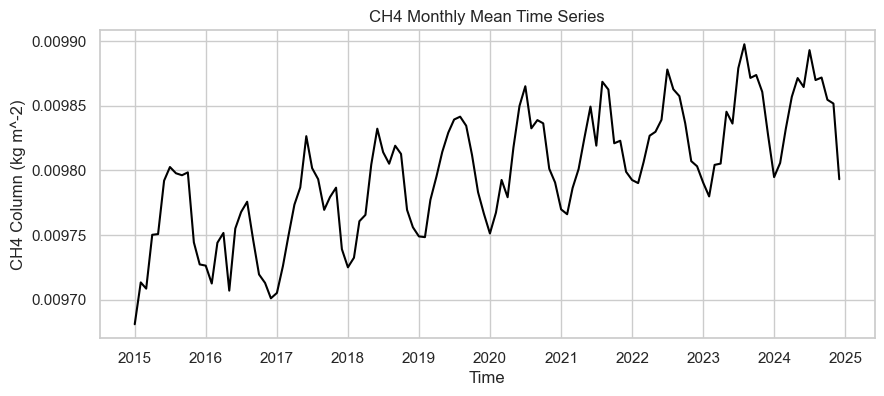

Saved: C:\Users\tanvi\Capstone\EDA\CH4_timeseries.png


In [124]:
fig = plt.figure(figsize=(10,4))
plt.plot(df_ch4["time"], df_ch4["value"], color="black")
plt.title("CH4 Monthly Mean Time Series")
plt.xlabel("Time")
plt.ylabel("CH4 Column (kg m^-2)")
plt.show()

save_plot(fig, "CH4_timeseries.png")



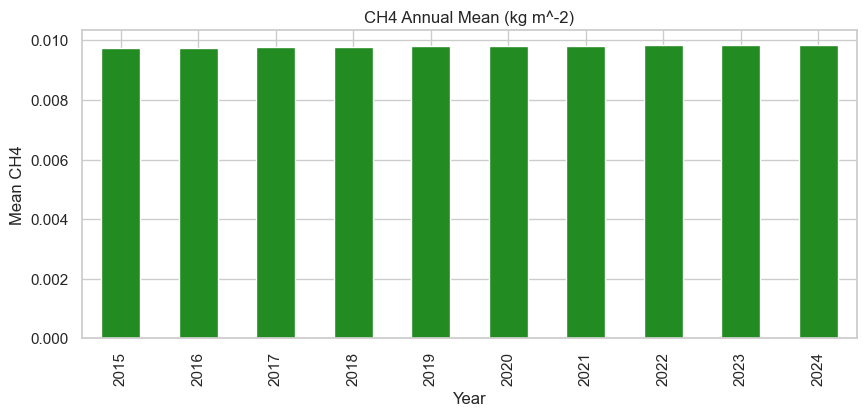

Saved: C:\Users\tanvi\Capstone\EDA\CH4_annual_mean.png


In [130]:
# Add year column
df_ch4["year"] = df_ch4["time"].dt.year

# Annual mean
annual_ch4 = df_ch4.groupby("year")["value"].mean()

fig = plt.figure(figsize=(10,4))
annual_ch4.plot(kind="bar", color="forestgreen")
plt.title("CH4 Annual Mean (kg m^-2)")
plt.ylabel("Mean CH4")
plt.xlabel("Year")
plt.show()

save_plot(fig, "CH4_annual_mean.png")


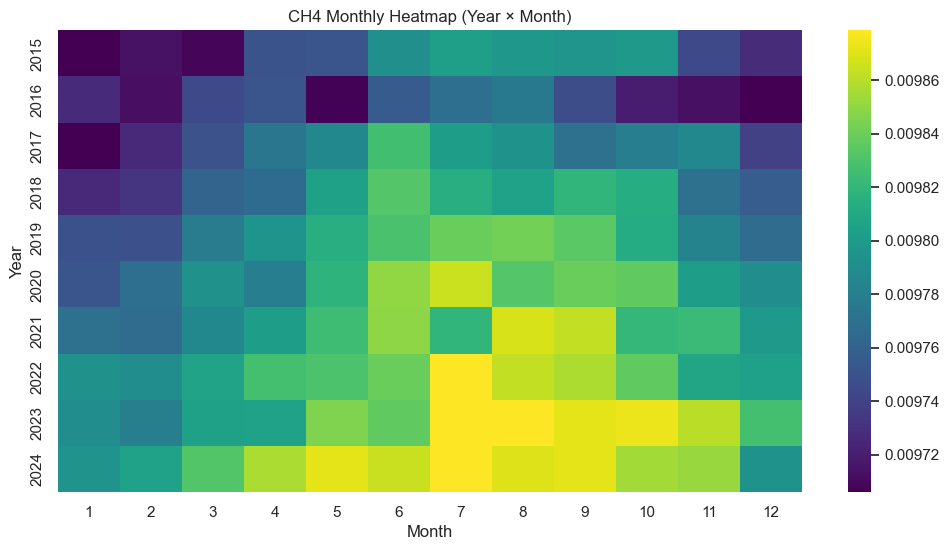

Saved: C:\Users\tanvi\Capstone\EDA\CH4_monthly_heatmap.png


In [136]:
# pivot: rows=year, columns=month
pivot_hm = df_ch4.pivot_table(index="year", columns="month", values="value")

fig = plt.figure(figsize=(12,6))
sns.heatmap(pivot_hm, cmap="viridis", robust=True)
plt.title("CH4 Monthly Heatmap (Year × Month)")
plt.xlabel("Month")
plt.ylabel("Year")
plt.show()

save_plot(fig, "CH4_monthly_heatmap.png")


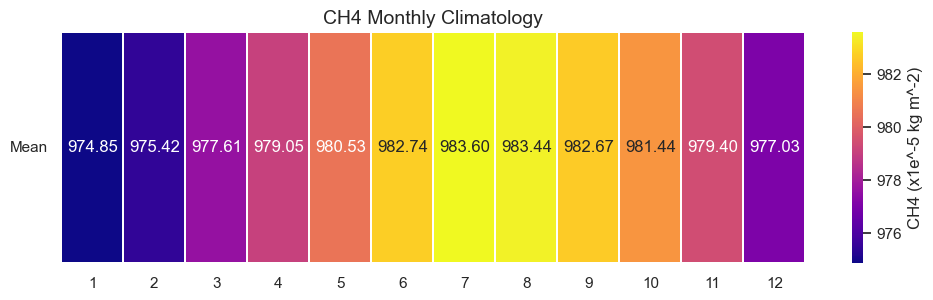

Saved: C:\Users\tanvi\Capstone\EDA\CH4_monthly_climatology.png


In [140]:
df_clim_ch4 = df_ch4.groupby("month")["value"].mean()

scaled_vals = (df_clim_ch4.values / 1e-5).reshape(1,12)

fig = plt.figure(figsize=(12,3))

sns.heatmap(
    scaled_vals,
    cmap="plasma",
    annot=True,
    fmt=".2f",
    cbar_kws={"label": "CH4 (x1e^-5 kg m^-2)"},
    linewidths=0.3,
    annot_kws={"size": 12}
)

plt.xticks(np.arange(12)+0.5, range(1,13), rotation=0)
plt.yticks([0.5], ["Mean"], rotation=0)

plt.title("CH4 Monthly Climatology", fontsize=14)
plt.show()

save_plot(fig, "CH4_monthly_climatology.png")


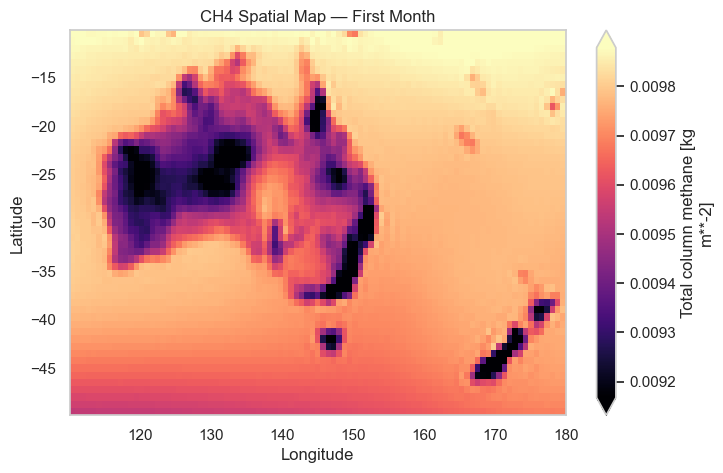

Saved: C:\Users\tanvi\Capstone\EDA\CH4_map_firstmonth.png


In [146]:
# ============================
# CH4 — SPATIAL MAP (FIRST)
# ============================

fig = plt.figure(figsize=(8,5))

da_ch4.isel(time=0).plot(
    cmap="magma",
    robust=True
)

plt.title("CH4 Spatial Map — First Month")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

save_plot(fig, "CH4_map_firstmonth.png")


# N2O

In [148]:
# ============================
# LOAD N2O DATASET (TOP-DOWN)
# ============================

n2o_path = r"C:\Users\tanvi\Capstone\N2O_topdown\CAMS_N2O_topdown_Australasia_2015_2022.nc"
ds_n2o = xr.open_dataset(n2o_path)

da_n2o = ds_n2o["N2O"]
print(da_n2o)


<xarray.DataArray 'N2O' (time: 96, latitude: 32, longitude: 28)> Size: 344kB
[86016 values with dtype=float32]
Coordinates:
  * time       (time) datetime64[ns] 768B 2015-01-01 2015-02-01 ... 2022-12-01
  * latitude   (latitude) float64 256B -49.09 -47.83 -46.57 ... -11.33 -10.07
  * longitude  (longitude) float64 224B 110.0 112.5 115.0 ... 172.5 175.0 177.5


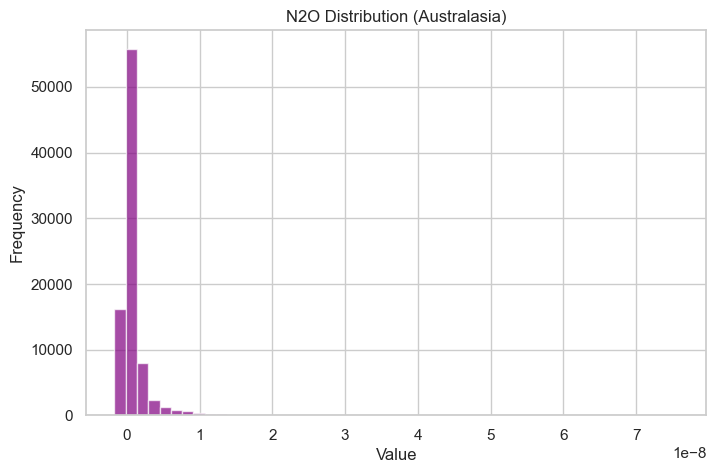

Saved: C:\Users\tanvi\Capstone\EDA\N2O_hist.png


In [153]:
# ===================================
# N2O — HISTOGRAM
# ===================================
data = da_n2o.values.flatten()

fig = plt.figure(figsize=(8,5))
plt.hist(data, bins=50, color="purple", alpha=0.7)
plt.title("N2O Distribution (Australasia)")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()

save_plot(fig, "N2O_hist.png")


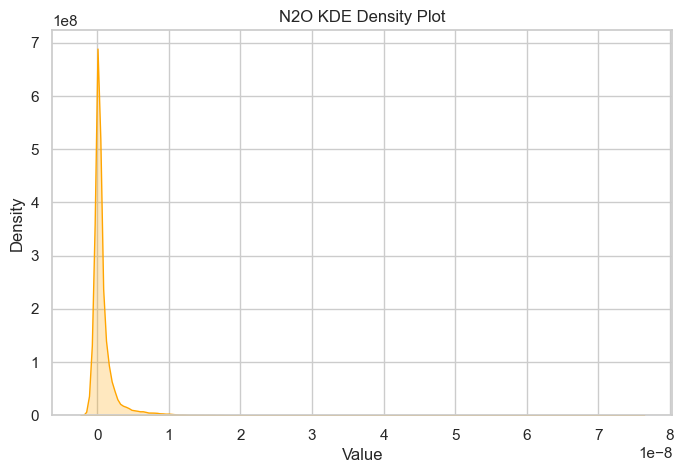

Saved: C:\Users\tanvi\Capstone\EDA\N2O_kde.png


In [157]:
# ===================================
# N2O — KDE DENSITY
# ===================================
fig = plt.figure(figsize=(8,5))
sns.kdeplot(data=data, fill=True, color="orange")
plt.title("N2O KDE Density Plot")
plt.xlabel("Value")
plt.ylabel("Density")
plt.show()

save_plot(fig, "N2O_kde.png")


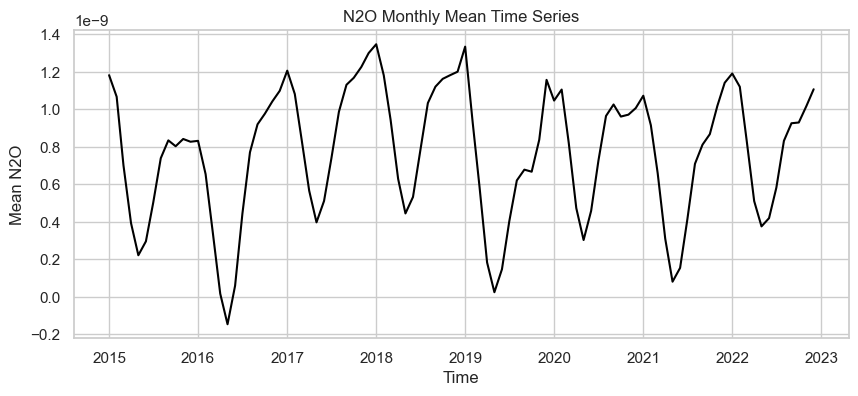

Saved: C:\Users\tanvi\Capstone\EDA\N2O_timeseries.png


In [155]:
# ===================================
# N2O — TIME SERIES (MONTHLY MEAN)
# ===================================
ts_n2o = da_n2o.mean(dim=["latitude","longitude"]).to_pandas()

fig = plt.figure(figsize=(10,4))
plt.plot(ts_n2o.index, ts_n2o.values, color="black")
plt.title("N2O Monthly Mean Time Series")
plt.xlabel("Time")
plt.ylabel("Mean N2O")
plt.show()

save_plot(fig, "N2O_timeseries.png")


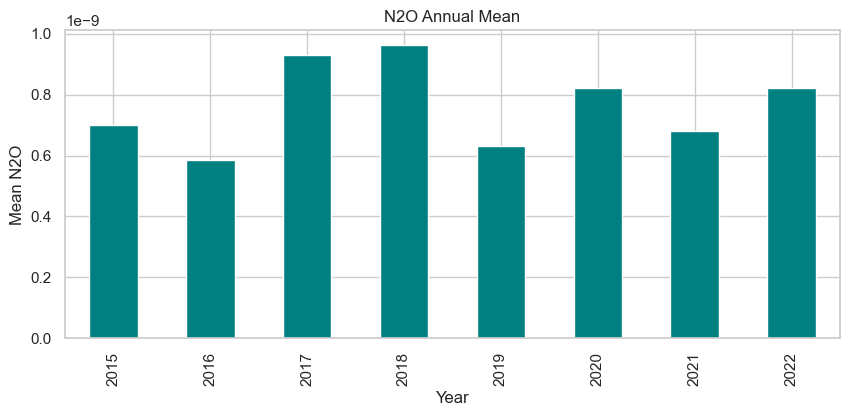

Saved: C:\Users\tanvi\Capstone\EDA\N2O_annual_mean.png


In [159]:
# ===================================
# N2O — ANNUAL MEAN
# ===================================
df_n2o = ts_n2o.to_frame(name="value")
df_n2o["year"] = df_n2o.index.year

annual_n2o = df_n2o.groupby("year")["value"].mean()

fig = plt.figure(figsize=(10,4))
annual_n2o.plot(kind="bar", color="teal")
plt.title("N2O Annual Mean")
plt.ylabel("Mean N2O")
plt.xlabel("Year")
plt.show()

save_plot(fig, "N2O_annual_mean.png")


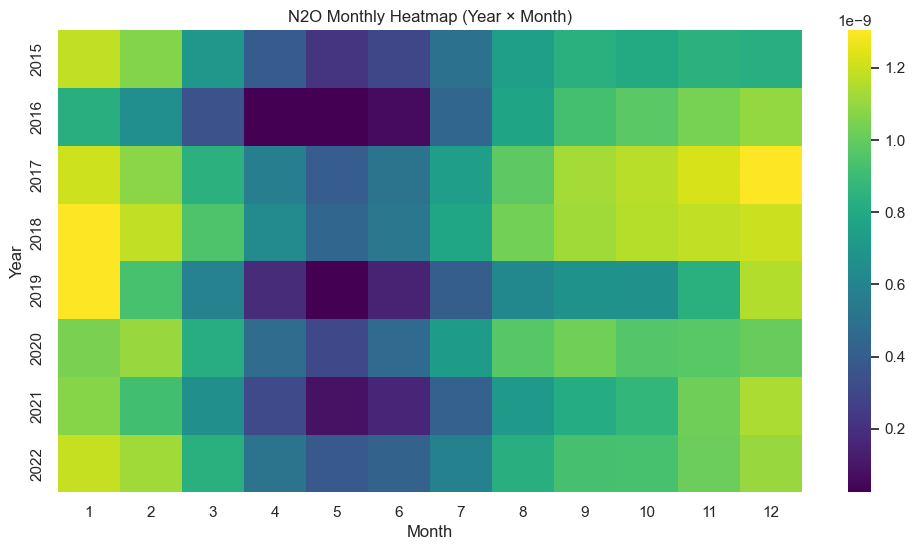

Saved: C:\Users\tanvi\Capstone\EDA\N2O_monthly_heatmap.png


In [161]:
# ===================================
# N2O — MONTHLY HEATMAP
# ===================================
df_n2o["month"] = df_n2o.index.month

pivot_hm = df_n2o.pivot_table(
    index="year",
    columns="month",
    values="value"
)

fig = plt.figure(figsize=(12,6))
sns.heatmap(pivot_hm, cmap="viridis", robust=True)
plt.title("N2O Monthly Heatmap (Year × Month)")
plt.xlabel("Month")
plt.ylabel("Year")
plt.show()

save_plot(fig, "N2O_monthly_heatmap.png")


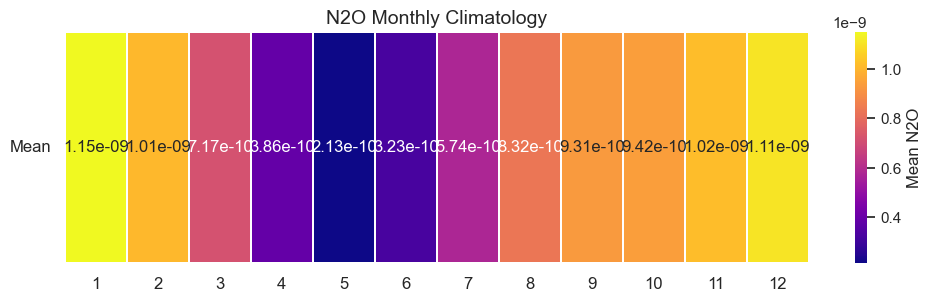

Saved: C:\Users\tanvi\Capstone\EDA\N2O_monthly_climatology.png


In [163]:
# =========================================
# N2O — MONTHLY CLIMATOLOGY
# =========================================
df_clim = df_n2o.groupby("month")["value"].mean()

scaled_vals = df_clim.values.reshape(1,12)

fig = plt.figure(figsize=(12,3))
ax = sns.heatmap(
    scaled_vals,
    cmap="plasma",
    annot=True,
    fmt=".2e",
    cbar_kws={"label": "Mean N2O"},
    linewidths=0.3,
    annot_kws={"size": 12}
)

plt.xticks(np.arange(12)+0.5, range(1,13), rotation=0, fontsize=12)
plt.yticks([0.5], ["Mean"], rotation=0, fontsize=12)
plt.title("N2O Monthly Climatology", fontsize=14)

plt.show()
save_plot(fig, "N2O_monthly_climatology.png")


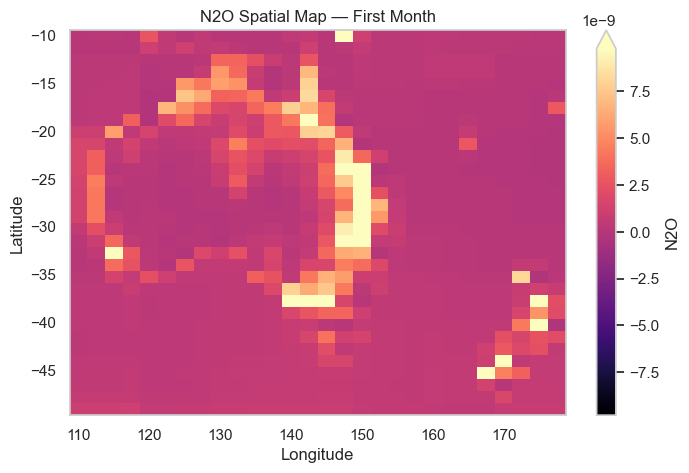

Saved: C:\Users\tanvi\Capstone\EDA\N2O_map_firstmonth.png


In [171]:
# ===================================
# N2O — FIRST-MONTH SPATIAL MAP
# ===================================
fig = plt.figure(figsize=(8,5))
da_n2o.isel(time=0).plot(cmap="magma", robust=True)
plt.title("N2O Spatial Map — First Month")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

save_plot(fig, "N2O_map_firstmonth.png")


# bottom-up

In [198]:
df_int = pd.read_csv(
    csv_path,
    parse_dates=["Date"],
    dayfirst=True
)

# rename
df_int.rename(columns={"Date": "date"}, inplace=True)

# add year, month
df_int["year"]  = df_int["date"].dt.year
df_int["month"] = df_int["date"].dt.month

df_int.head()


,date,CO2,CH4,N2O,NOx,year,month
0,2015-01-01,11828691.0,716344.40,23644.908,51183.125,2015,1
1,2015-02-01,11583197.0,708141.70,23653.059,51204.652,2015,2
2,2015-03-01,12158137.0,705938.30,23817.104,57834.668,2015,3
3,2015-04-01,12648072.0,704179.90,23922.896,61536.957,2015,4
4,2015-05-01,12213151.0,756249.25,23803.586,57048.137,2015,5


In [200]:
def eda_hist_csv(df, gas):
    fig = plt.figure(figsize=(8,5))
    plt.hist(df[gas].dropna(), bins=50, color="purple", alpha=0.7)
    plt.title(f"{gas} Integrated — Distribution")
    plt.xlabel("Value")
    plt.ylabel("Frequency")
    plt.show()

    save_plot(fig, f"{gas}_INT_hist.png")


In [202]:
def eda_timeseries_csv(df, gas):
    fig = plt.figure(figsize=(10,4))
    plt.plot(df["date"], df[gas], color="black")
    plt.title(f"{gas} Integrated — Monthly Trend")
    plt.ylabel("Value")
    plt.xlabel("Date")
    plt.show()

    save_plot(fig, f"{gas}_INT_timeseries.png")


In [204]:
def eda_annual_csv(df, gas):
    df["year"] = df["date"].dt.year
    annual = df.groupby("year")[gas].mean()

    fig = plt.figure(figsize=(10,4))
    annual.plot(kind="bar", color="teal")
    plt.title(f"{gas} Integrated — Annual Mean")
    plt.ylabel("Mean Value")
    plt.xlabel("Year")
    plt.show()

    save_plot(fig, f"{gas}_INT_annual_mean.png")


In [206]:
def eda_kde_csv(df, gas):
    fig = plt.figure(figsize=(8,5))
    sns.kdeplot(df[gas].dropna(), fill=True, color="orange")
    plt.title(f"{gas} Integrated — KDE")
    plt.xlabel("Value")
    plt.ylabel("Density")
    plt.show()

    save_plot(fig, f"{gas}_INT_kde.png")


In [208]:
def eda_heatmap_csv(df, gas):
    df["year"] = df["date"].dt.year
    df["month"] = df["date"].dt.month

    pivot = df.pivot_table(index="year", columns="month", values=gas)

    fig = plt.figure(figsize=(12,6))
    sns.heatmap(pivot, cmap="viridis", robust=True)
    plt.title(f"{gas} Integrated — Monthly Heatmap")
    plt.xlabel("Month")
    plt.ylabel("Year")
    plt.show()

    save_plot(fig, f"{gas}_INT_monthly_heatmap.png")


In [210]:
def eda_climatology_csv(df, gas):
    df["month"] = df["date"].dt.month
    clim = df.groupby("month")[gas].mean()
    vals = clim.values.reshape(1,12)

    fig = plt.figure(figsize=(12,3))
    sns.heatmap(vals, cmap="plasma", annot=True, fmt=".2e",
                cbar_kws={"label": f"{gas} Value"})
    plt.xticks(np.arange(12)+0.5, range(1,13), rotation=0)
    plt.yticks([0.5], ["Mean"], rotation=0)
    plt.title(f"{gas} Integrated — Monthly Climatology")
    plt.show()

    save_plot(fig, f"{gas}_INT_climatology.png")


EDA for: CO2


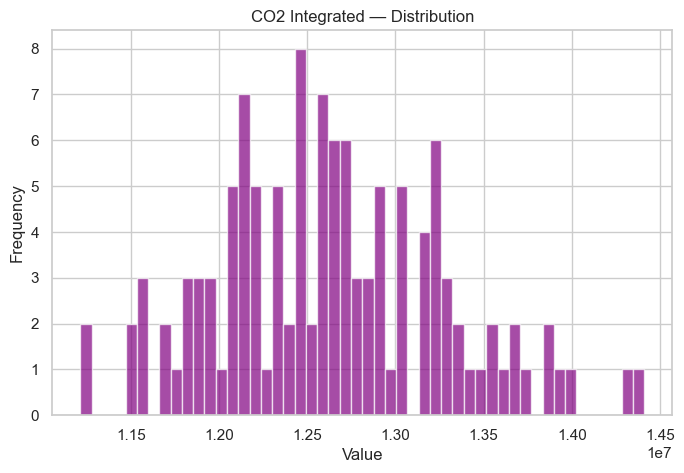

Saved: C:\Users\tanvi\Capstone\EDA\CO2_INT_hist.png


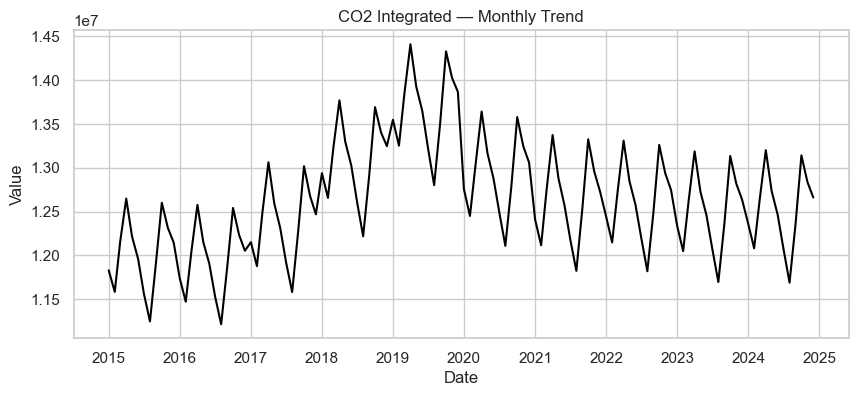

Saved: C:\Users\tanvi\Capstone\EDA\CO2_INT_timeseries.png


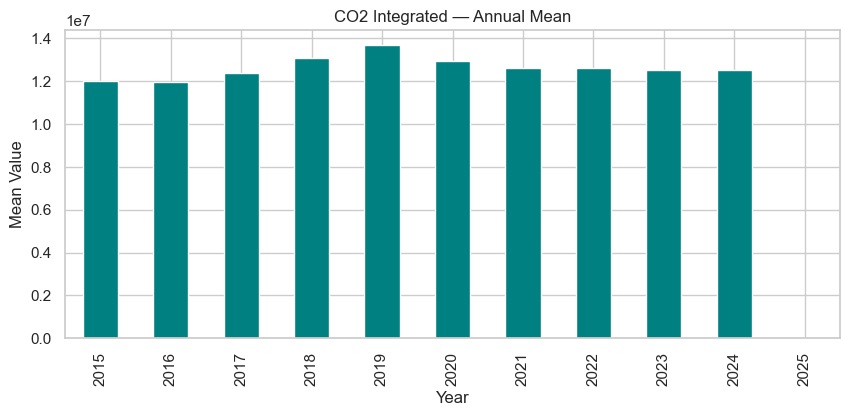

Saved: C:\Users\tanvi\Capstone\EDA\CO2_INT_annual_mean.png


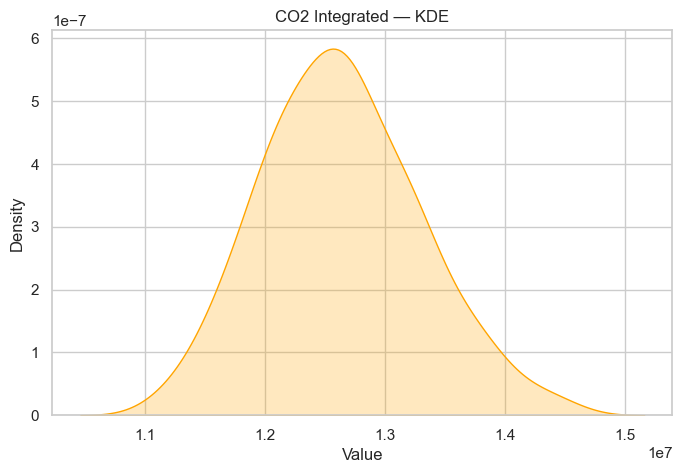

Saved: C:\Users\tanvi\Capstone\EDA\CO2_INT_kde.png


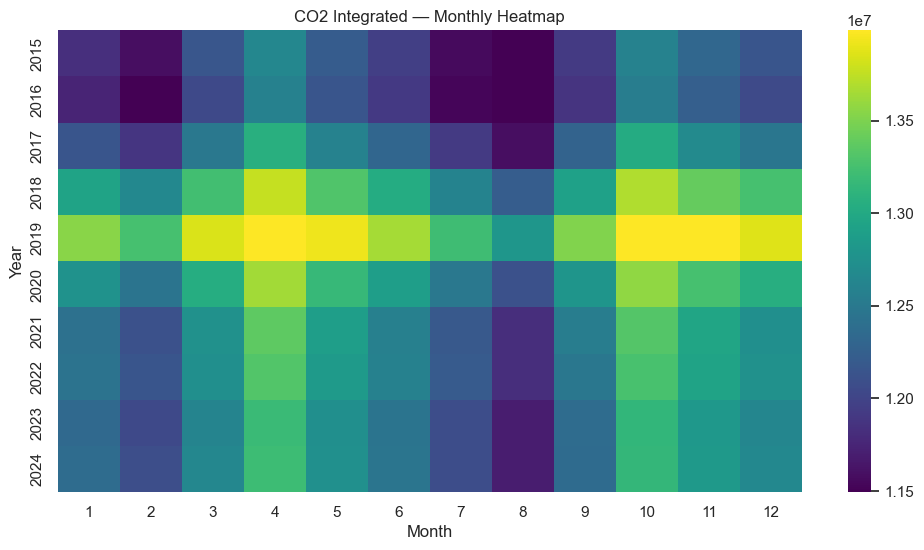

Saved: C:\Users\tanvi\Capstone\EDA\CO2_INT_monthly_heatmap.png


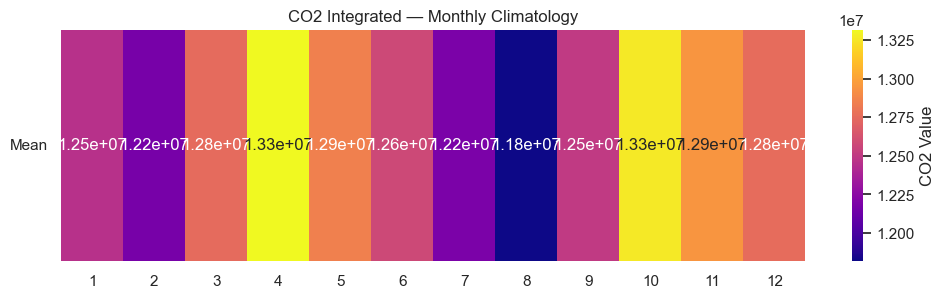

Saved: C:\Users\tanvi\Capstone\EDA\CO2_INT_climatology.png
EDA for: CH4


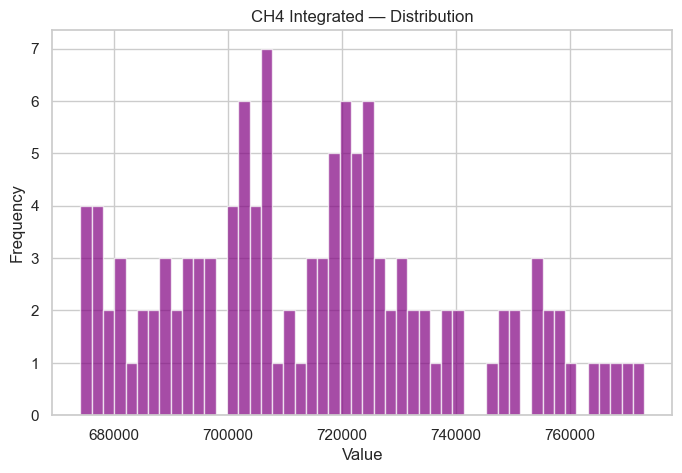

Saved: C:\Users\tanvi\Capstone\EDA\CH4_INT_hist.png


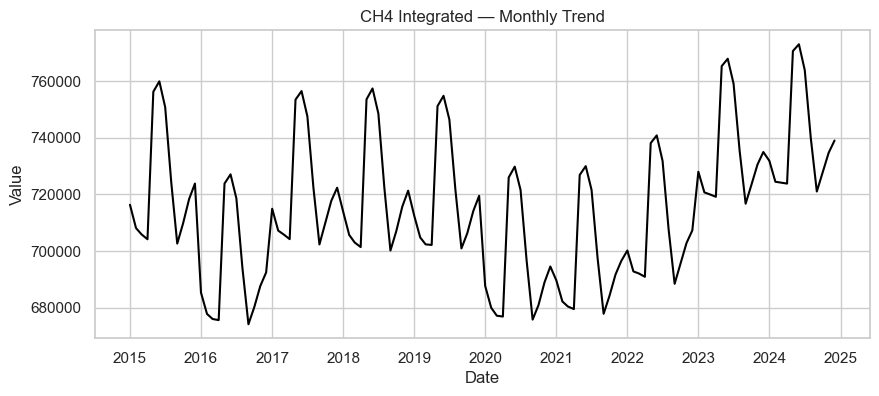

Saved: C:\Users\tanvi\Capstone\EDA\CH4_INT_timeseries.png


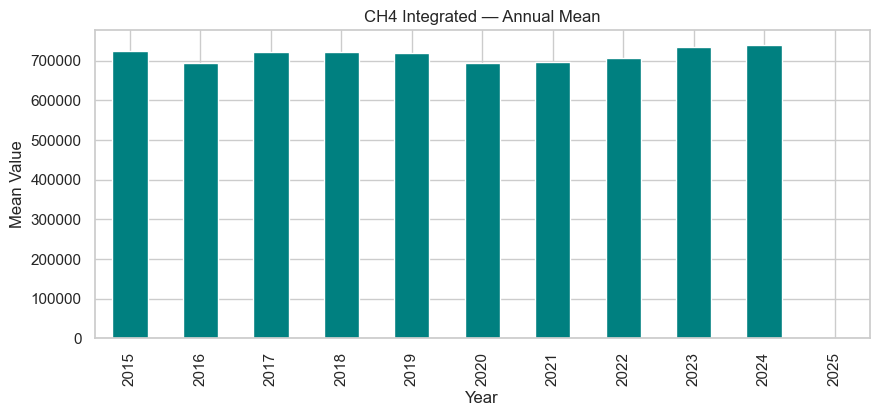

Saved: C:\Users\tanvi\Capstone\EDA\CH4_INT_annual_mean.png


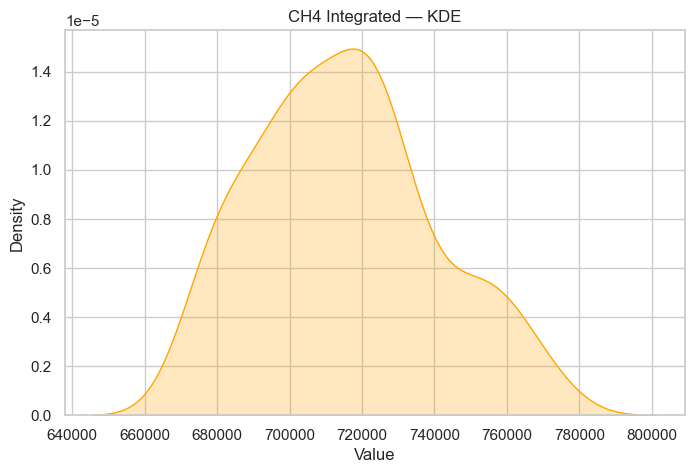

Saved: C:\Users\tanvi\Capstone\EDA\CH4_INT_kde.png


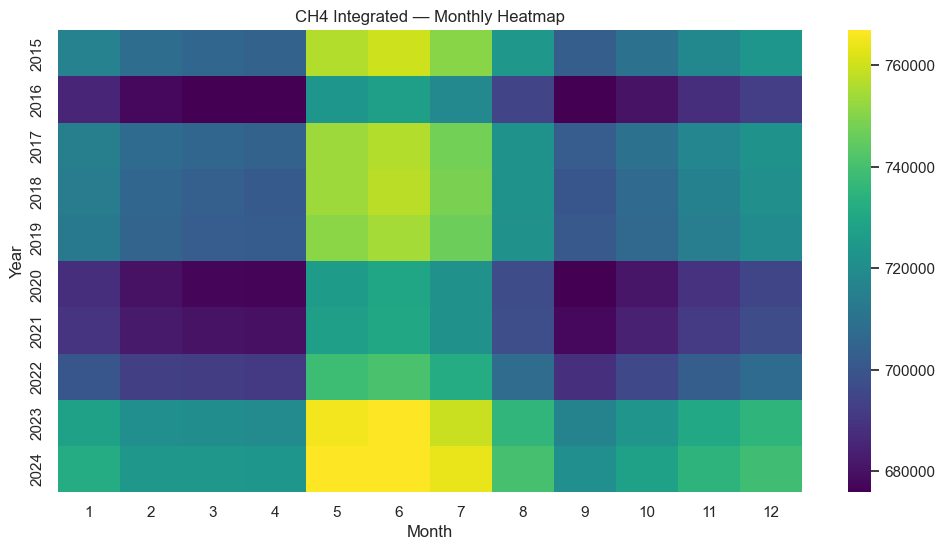

Saved: C:\Users\tanvi\Capstone\EDA\CH4_INT_monthly_heatmap.png


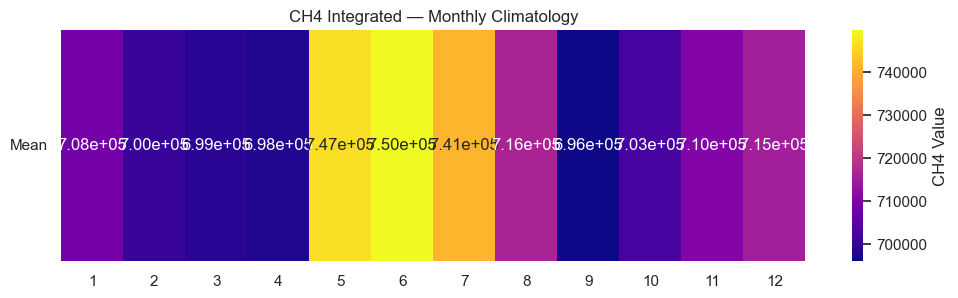

Saved: C:\Users\tanvi\Capstone\EDA\CH4_INT_climatology.png
EDA for: N2O


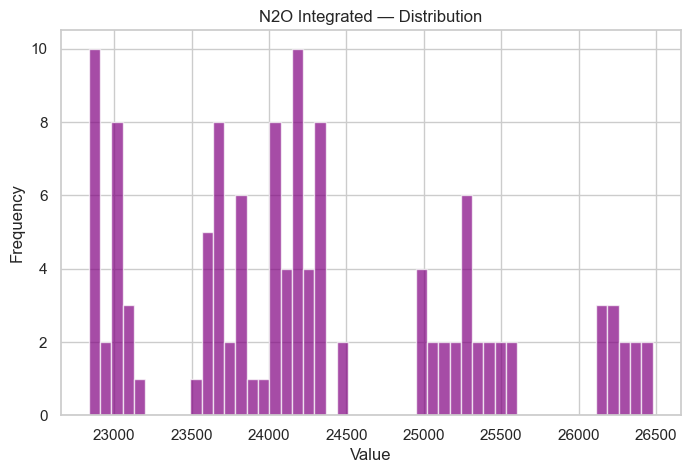

Saved: C:\Users\tanvi\Capstone\EDA\N2O_INT_hist.png


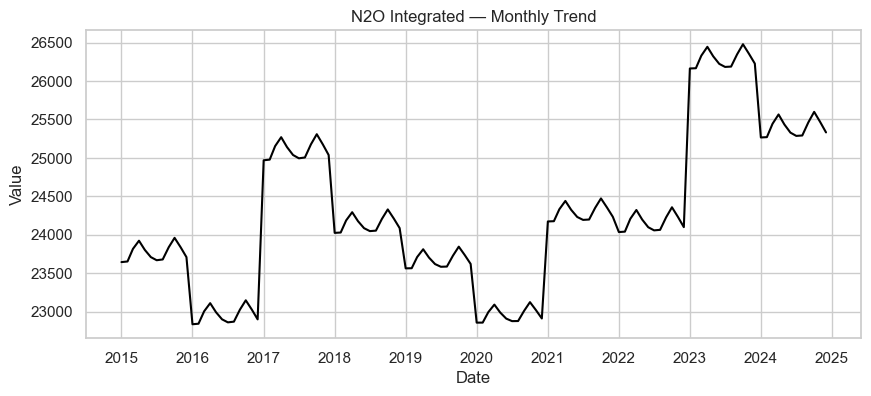

Saved: C:\Users\tanvi\Capstone\EDA\N2O_INT_timeseries.png


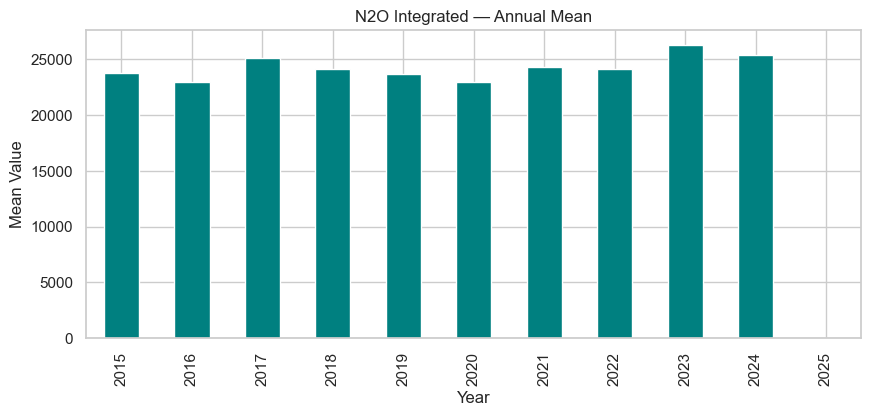

Saved: C:\Users\tanvi\Capstone\EDA\N2O_INT_annual_mean.png


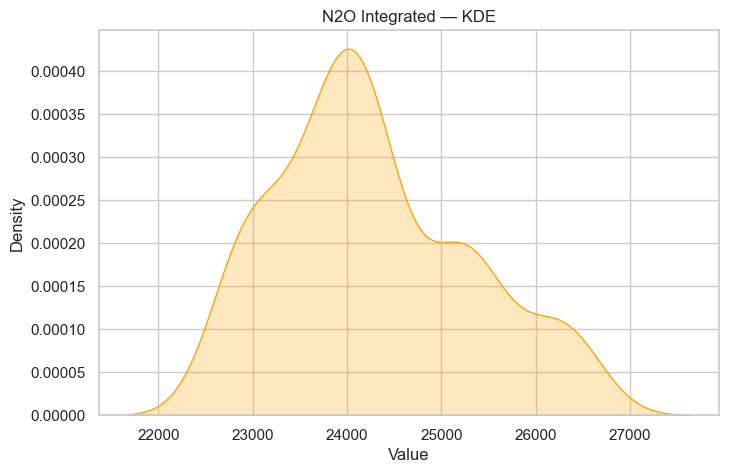

Saved: C:\Users\tanvi\Capstone\EDA\N2O_INT_kde.png


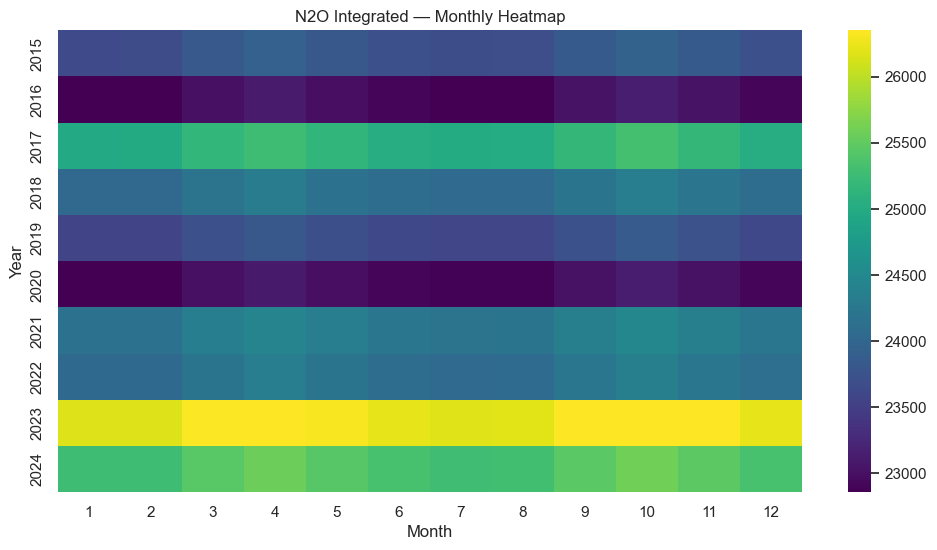

Saved: C:\Users\tanvi\Capstone\EDA\N2O_INT_monthly_heatmap.png


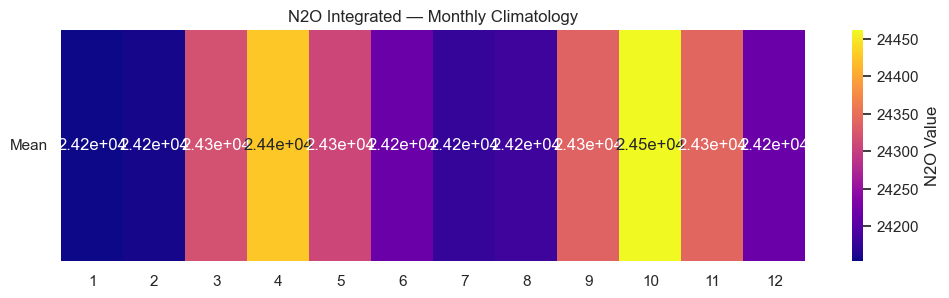

Saved: C:\Users\tanvi\Capstone\EDA\N2O_INT_climatology.png
EDA for: NOx


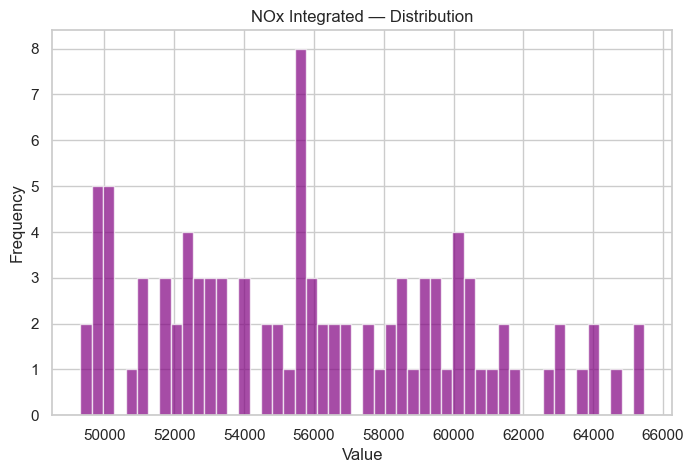

Saved: C:\Users\tanvi\Capstone\EDA\NOx_INT_hist.png


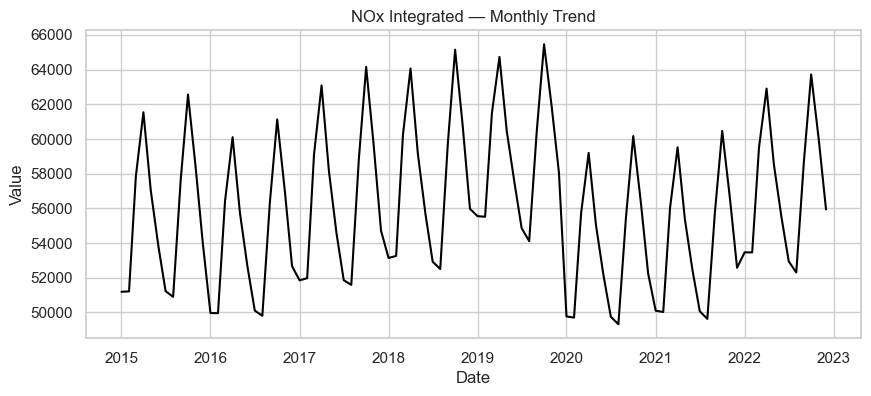

Saved: C:\Users\tanvi\Capstone\EDA\NOx_INT_timeseries.png


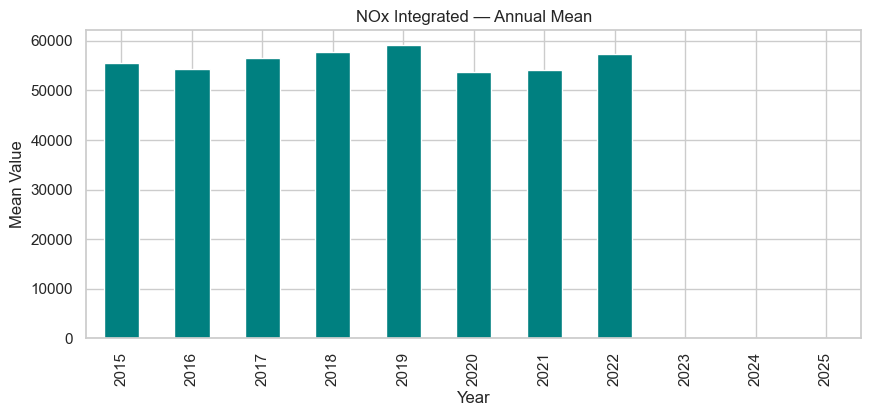

Saved: C:\Users\tanvi\Capstone\EDA\NOx_INT_annual_mean.png


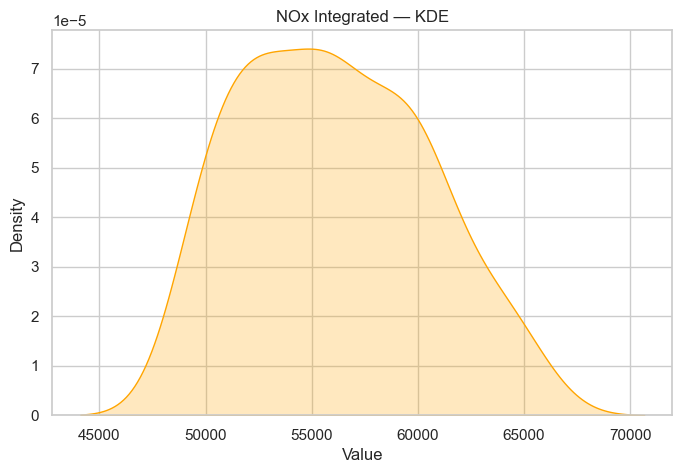

Saved: C:\Users\tanvi\Capstone\EDA\NOx_INT_kde.png


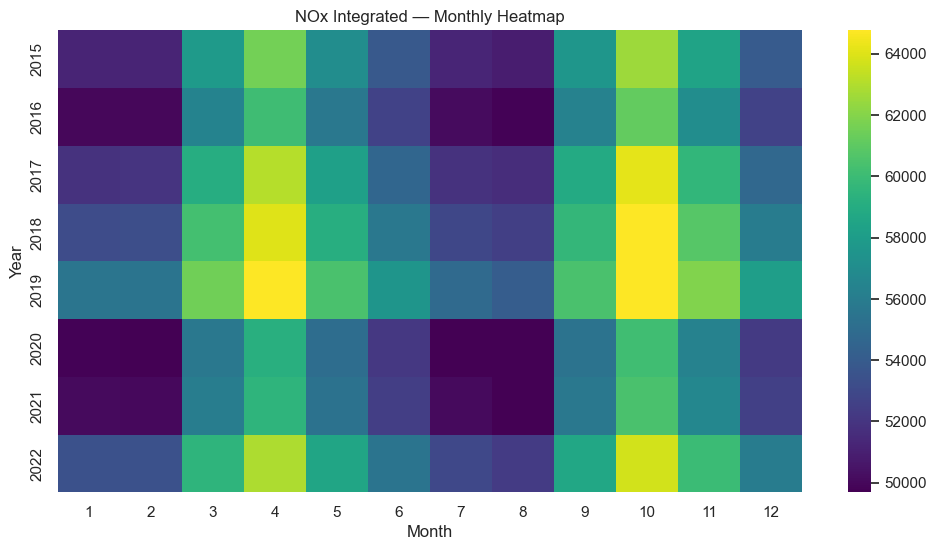

Saved: C:\Users\tanvi\Capstone\EDA\NOx_INT_monthly_heatmap.png


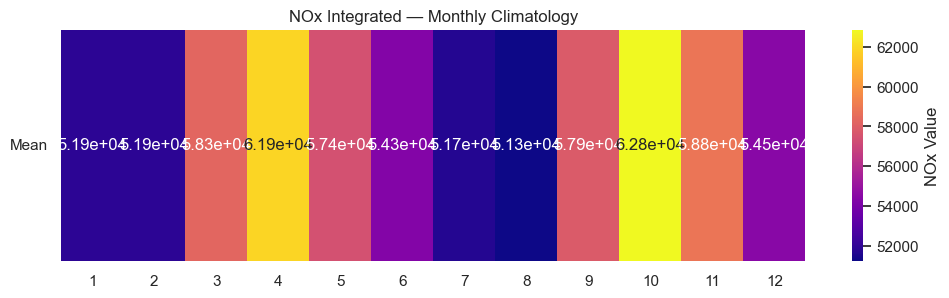

Saved: C:\Users\tanvi\Capstone\EDA\NOx_INT_climatology.png


In [214]:
gases = ["CO2", "CH4", "N2O", "NOx"]  # adjust based on your file

for gas in gases:
    print("EDA for:", gas)

    eda_hist_csv(df_int, gas)
    eda_timeseries_csv(df_int, gas)
    eda_annual_csv(df_int, gas)
    eda_kde_csv(df_int, gas)
    eda_heatmap_csv(df_int, gas)
    eda_climatology_csv(df_int, gas)


# Spatial maps

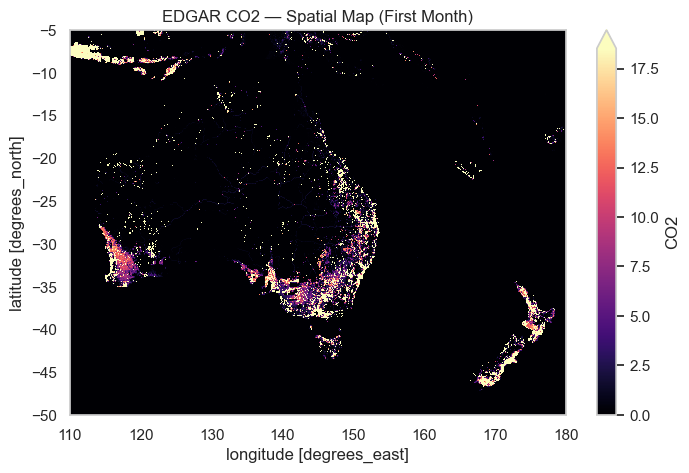

Saved: EDGAR_CO2_map_firstmonth.png


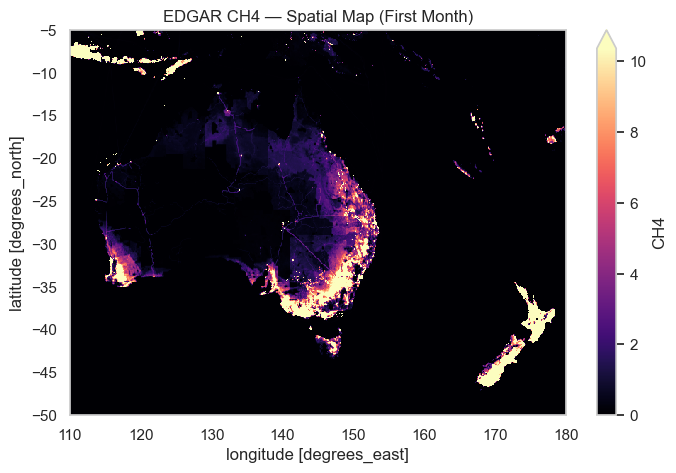

Saved: EDGAR_CH4_map_firstmonth.png


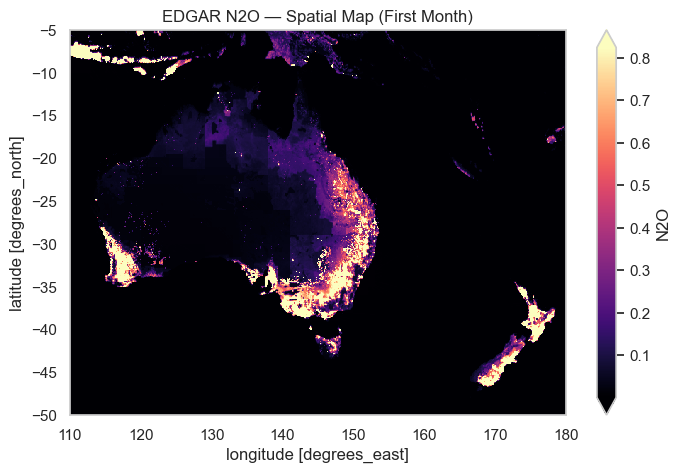

Saved: EDGAR_N2O_map_firstmonth.png


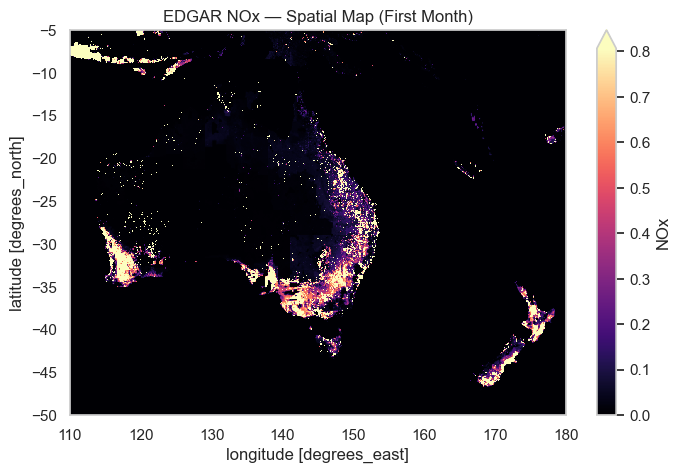

Saved: EDGAR_NOx_map_firstmonth.png


In [217]:
# ============================================
# EDGAR BOTTOM-UP SPATIAL MAPS FOR ALL GASES
# ============================================

import xarray as xr
import matplotlib.pyplot as plt
import os

eda_dir = r"C:\Users\tanvi\Capstone\EDA"

nc_path = r"C:\Users\tanvi\Downloads\EDGAR_Merged\EDGAR_BottomUp_AllGases_2015_2024.nc"
ds_edgar = xr.open_dataset(nc_path)

# List of gases in EDGAR
gases = ["CO2", "CH4", "N2O", "NOx"]

def save_spatial_plot(da, gas_name):
    fig = plt.figure(figsize=(8,5))
    da.isel(time=0).plot(cmap="magma", robust=True)
    plt.title(f"EDGAR {gas_name} — Spatial Map (First Month)")
    plt.savefig(os.path.join(eda_dir, f"EDGAR_{gas_name}_map_firstmonth.png"),
                dpi=200, bbox_inches="tight")
    plt.show()
    plt.close(fig)
    print("Saved:", f"EDGAR_{gas_name}_map_firstmonth.png")

# Generate maps
for gas in gases:
    da = ds_edgar[gas]
    save_spatial_plot(da, gas)


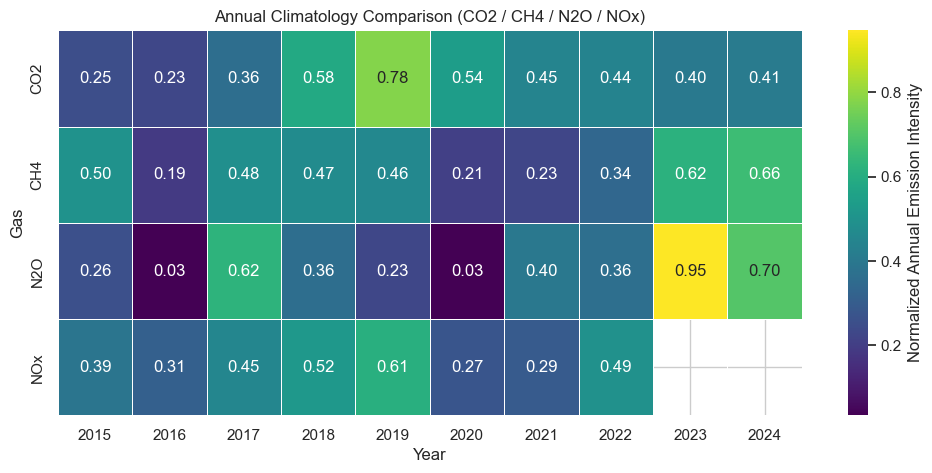

Saved: EDGAR_AllGases_Annual_Heatmap.png


In [221]:
# ============================================
# COMBINED MULTI-GAS HEATMAP (BY YEAR)
# ============================================

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Convert dataset to dataframe (mean over space)
df_all = (
    ds_edgar.mean(dim=["lat", "lon"])
    .to_dataframe()
    .reset_index()
)

# Standardize date columns
df_all["year"] = df_all["time"].dt.year

# Extract gases
gases = ["CO2", "CH4", "N2O", "NOx"]

# Normalize each gas 0–1
df_norm = df_all.copy()
for g in gases:
    df_norm[g] = (df_all[g] - df_all[g].min()) / (df_all[g].max() - df_all[g].min())

# Create heatmap table: rows = gas, columns = year (mean for each year)
pivot_year = df_norm.groupby("year")[gases].mean().T

fig = plt.figure(figsize=(12,5))
sns.heatmap(
    pivot_year,
    cmap="viridis",
    annot=True,
    fmt=".2f",
    linewidths=0.4,
    cbar_kws={"label": "Normalized Annual Emission Intensity"}
)

plt.title("Annual Climatology Comparison (CO2 / CH4 / N2O / NOx)")
plt.xlabel("Year")
plt.ylabel("Gas")
plt.show()

# Save figure
fig.savefig(
    os.path.join(eda_dir, "EDGAR_AllGases_Annual_Heatmap.png"),
    dpi=200,
    bbox_inches="tight"
)
plt.close(fig)

print("Saved: EDGAR_AllGases_Annual_Heatmap.png")


In [223]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

# Load your file
ds = xr.open_dataset("CAMS_NO2_topdown_Australasia_2015_2025.nc")

var = "ColumnAmountNO2TropCloudScreened"
da = ds[var]

print(da)
print("Total NaNs:", np.isnan(da).sum().item())


<xarray.DataArray 'ColumnAmountNO2TropCloudScreened' (Time: 129, lat: 160,
                                                      lon: 360)> Size: 30MB
[7430400 values with dtype=float32]
Coordinates:
  * Time     (Time) datetime64[ns] 1kB 2015-01-01 2015-02-01 ... 2025-09-01
  * lat      (lat) float64 1kB -49.94 -49.69 -49.44 ... -10.64 -10.39 -10.14
  * lon      (lon) float64 3kB 90.19 90.44 90.69 90.94 ... 179.5 179.7 180.0
Total NaNs: 599777


In [236]:
import numpy as np
import xarray as xr

ds = xr.open_dataset(r"C:\Users\tanvi\Capstone\CAMS_NO2_topdown_Australasia_2015_2025.nc")

var = "ColumnAmountNO2TropCloudScreened"
data = ds[var].values

print("Min:", np.nanmin(data))
print("Max:", np.nanmax(data))
print("Typical sample:", data[0, :5, :5])


Min: 192292700.0
Max: 7952650600000000.0
Typical sample: [[           nan 4.51596643e+13 1.27645187e+14 3.93161852e+13
  7.83889329e+13]
 [           nan            nan 1.32707468e+14 9.62787048e+13
  7.27669801e+13]
 [7.53502771e+13 3.01635302e+13 1.32151564e+14 1.37618713e+14
  1.33370219e+14]
 [1.81828313e+14 8.88680659e+13 1.48212543e+14 4.54610418e+13
  9.11536428e+13]
 [8.32158889e+13 1.17825205e+14 1.96430682e+14 7.53190966e+13
  1.09375184e+14]]


In [238]:
import xarray as xr
import numpy as np

ds = xr.open_dataset(r"C:\Users\tanvi\Capstone\N2O_topdown\CAMS_N2O_topdown_Australasia_2015_2022.nc")

var = "N2O"
data = ds[var].values

print("Min:", np.nanmin(data))
print("Max:", np.nanmax(data))

# optional: print small sample
print("\nSample grid:")
print(data[0, :5, :5])


Min: -1.7101256e-09
Max: 7.577111e-08

Sample grid:
[[1.0701710e-09 1.0648152e-09 1.0700713e-09 1.0860466e-09 6.8184997e-10]
 [7.1489603e-10 7.1038703e-10 7.1834283e-10 7.3868961e-10 4.6021073e-10]
 [5.0928012e-10 5.1757942e-10 5.2771554e-10 5.3988131e-10 3.3859102e-10]
 [5.0398508e-10 5.1061472e-10 5.2163823e-10 5.3731763e-10 3.4088851e-10]
 [4.1677700e-10 4.2081519e-10 4.3195555e-10 4.5056775e-10 3.3555339e-10]]
